# Vehicle Detection and Tracking
## Udacity Self Driving Car Engineer Nanodegree - Project 5

The goal of this project is to use Histogram of Oriented Gradients to:
- Identify vehicles in images
- Track vehicles across frames in a video stream

In [1]:
# Import Libraries
import cv2
import numpy as np
import pandas as pd
import time
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import seaborn as sns
from IPython.display import HTML

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from skimage.io import imread
%matplotlib inline
print('Loaded')

Loaded


# Import the dataset
The first step is to import the dataset.

In [2]:
#Import the training data
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')
print('Number of Vehicle Images: ',len(cars))
print('Number of Non-Vehicle Images: ',len(notcars))

Number of Vehicle Images:  8792
Number of Non-Vehicle Images:  8968


# Histogram of Oriented Gradients
Next, `get_hog_features` which will be used to compute a Histogram of Oriented Gradients for a given image.  

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# single_img_features
used to extract image from a single image window much similar to extract_features() 

In [4]:
# Define a function to extract features from a single image window
def single_img_features(img, color_space, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis==True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis==True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# bin_spatial
used to resize the image to 32x32 using cv2.resize and create features vector

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features0 = cv2.resize(img[:,:,0], size).ravel()
    features1 = cv2.resize(img[:,:,1], size).ravel()
    features2 = cv2.resize(img[:,:,2], size).ravel() 
    # Return the feature vector
    return np.hstack((features0,features1,features2))

# color_hist
used to calcuate color histogram features returns indivuaial histograms and bincenters as concatenated values

In [6]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [7]:
#define a function for plotting multipe images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

# Randomly display some car and non car images with visualizations of their HOG features.  

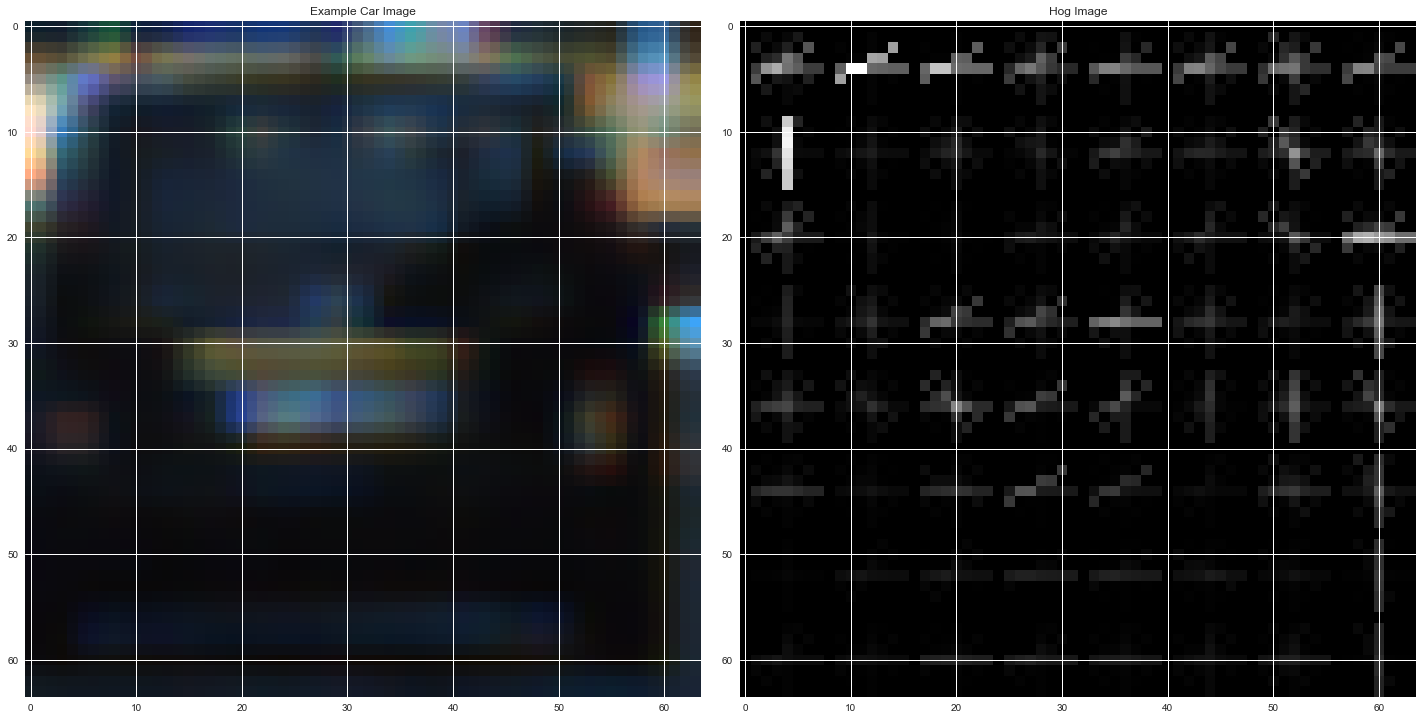

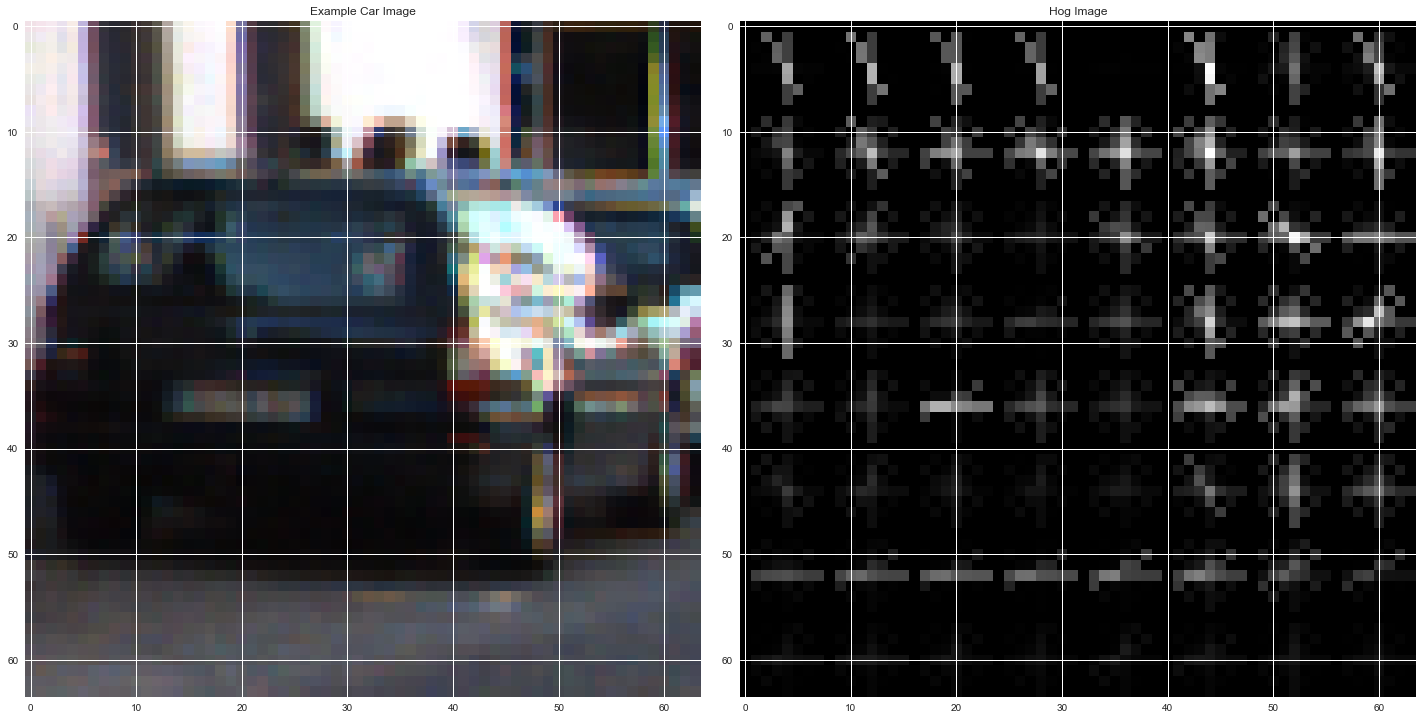

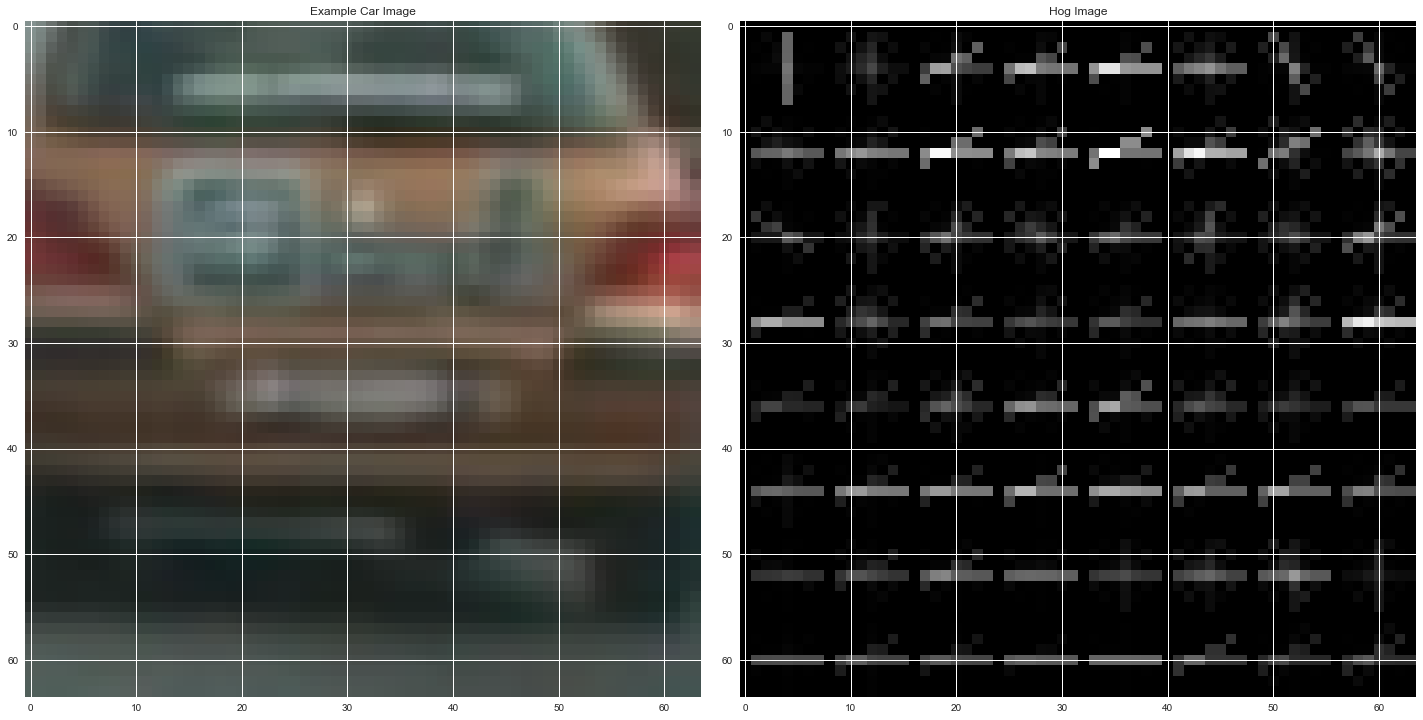

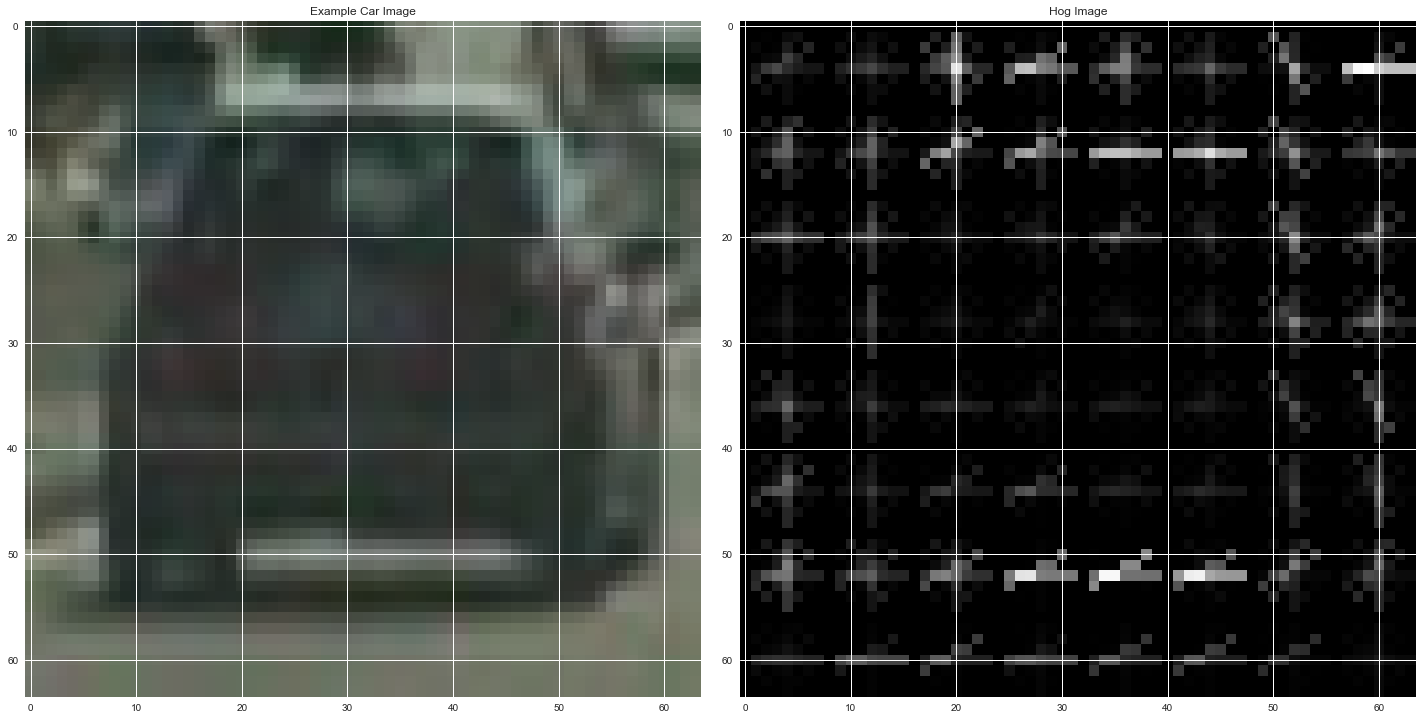

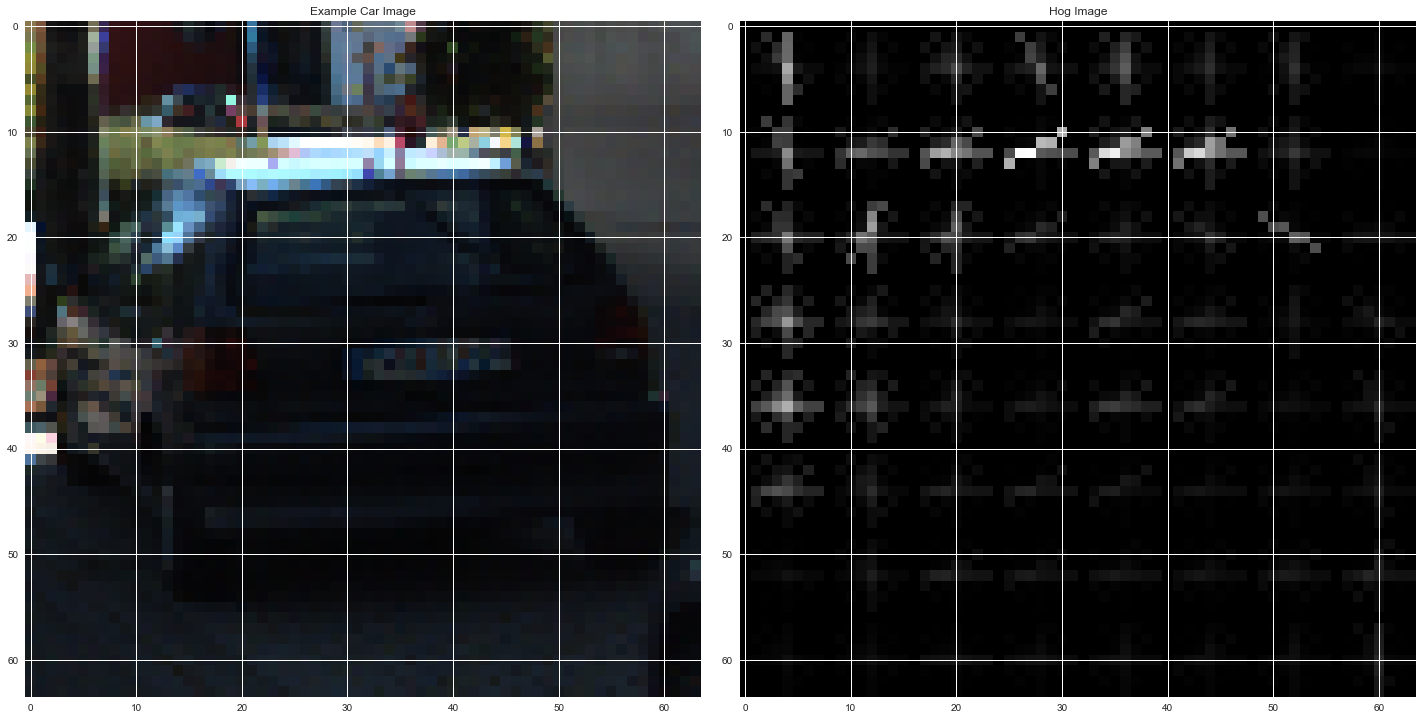

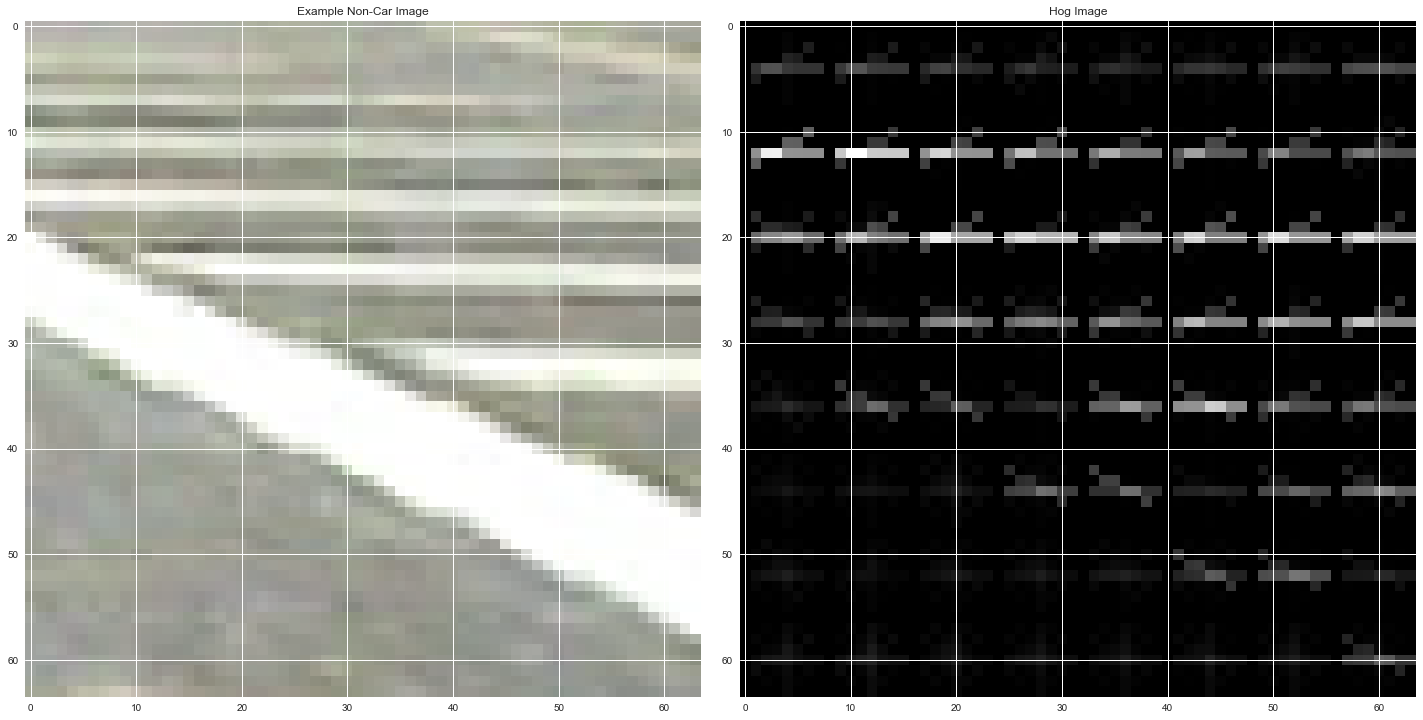

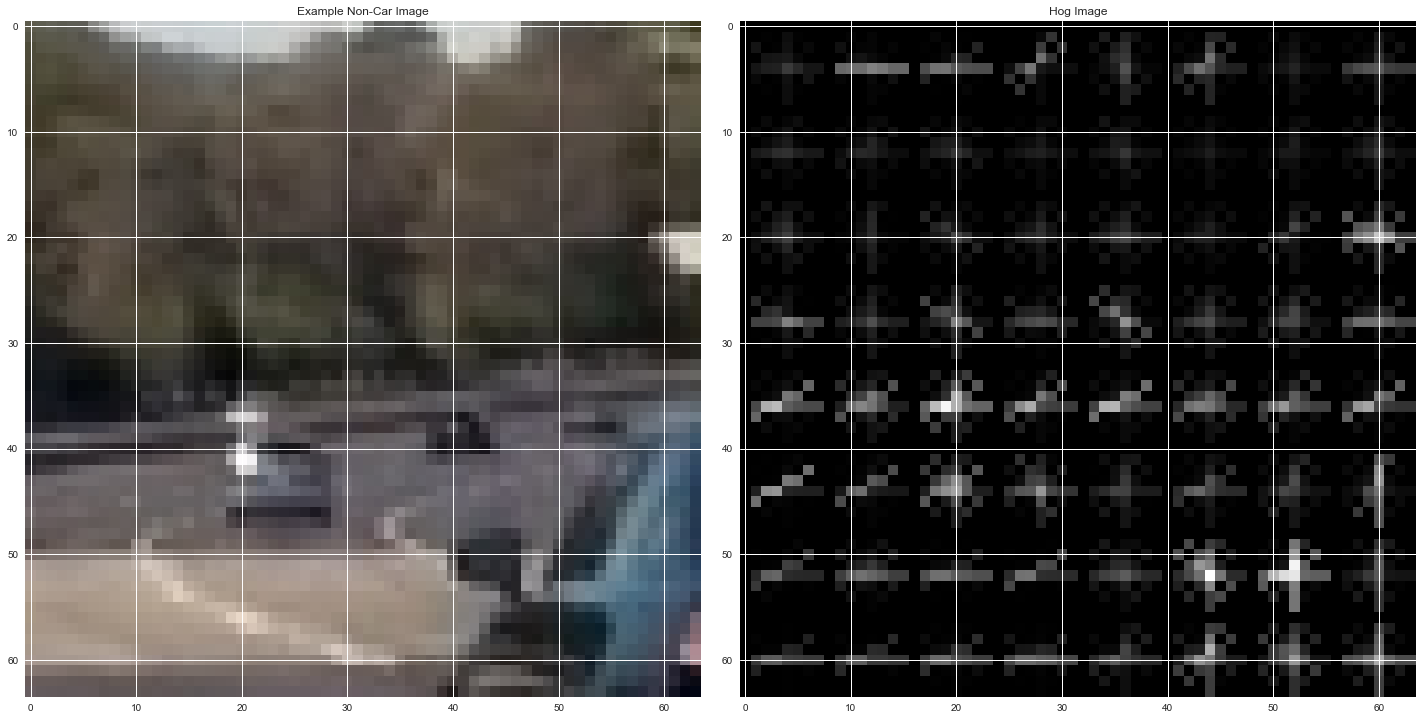

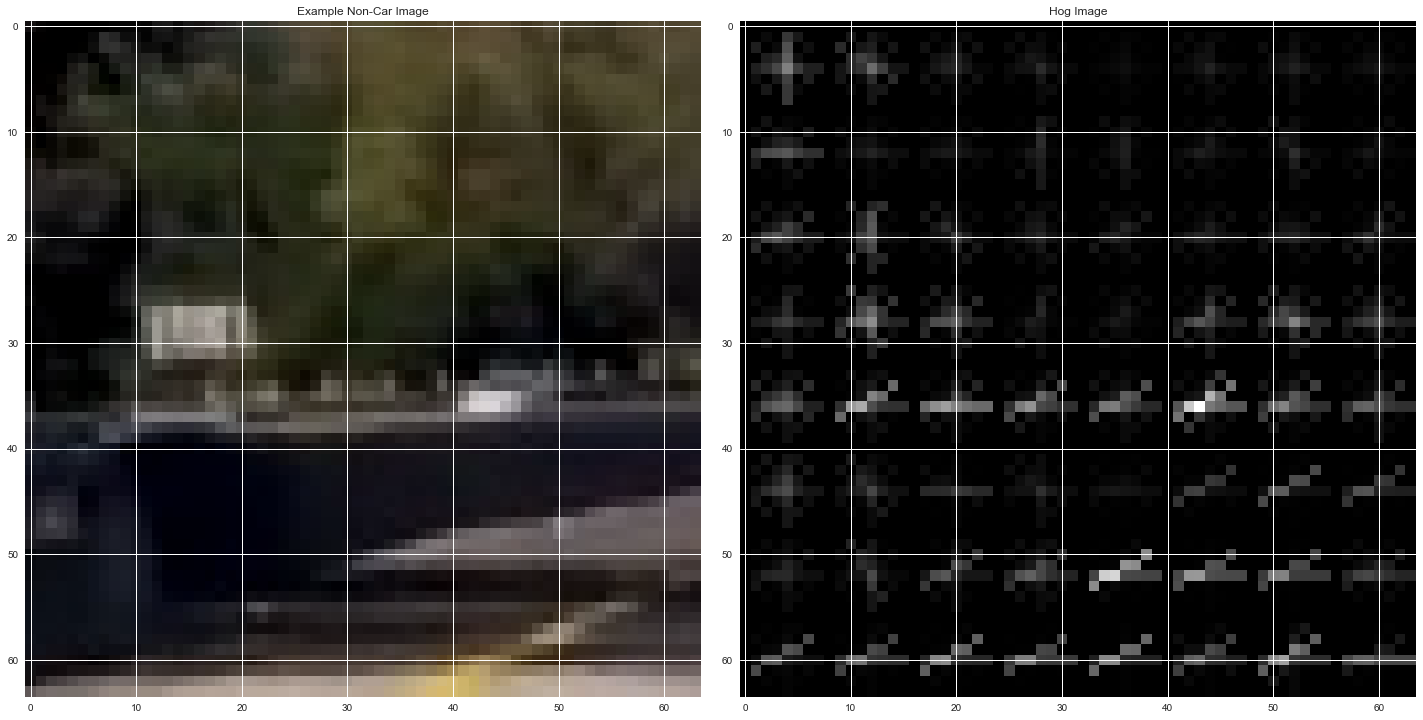

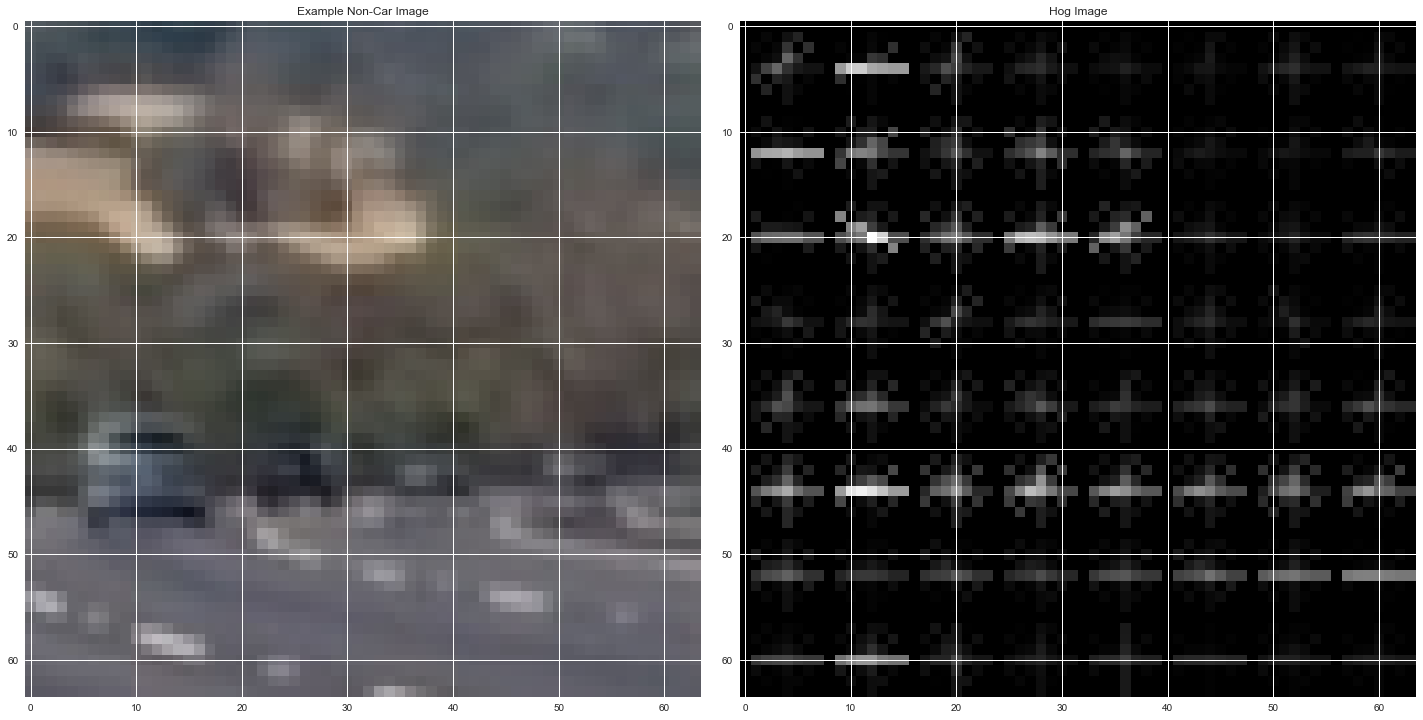

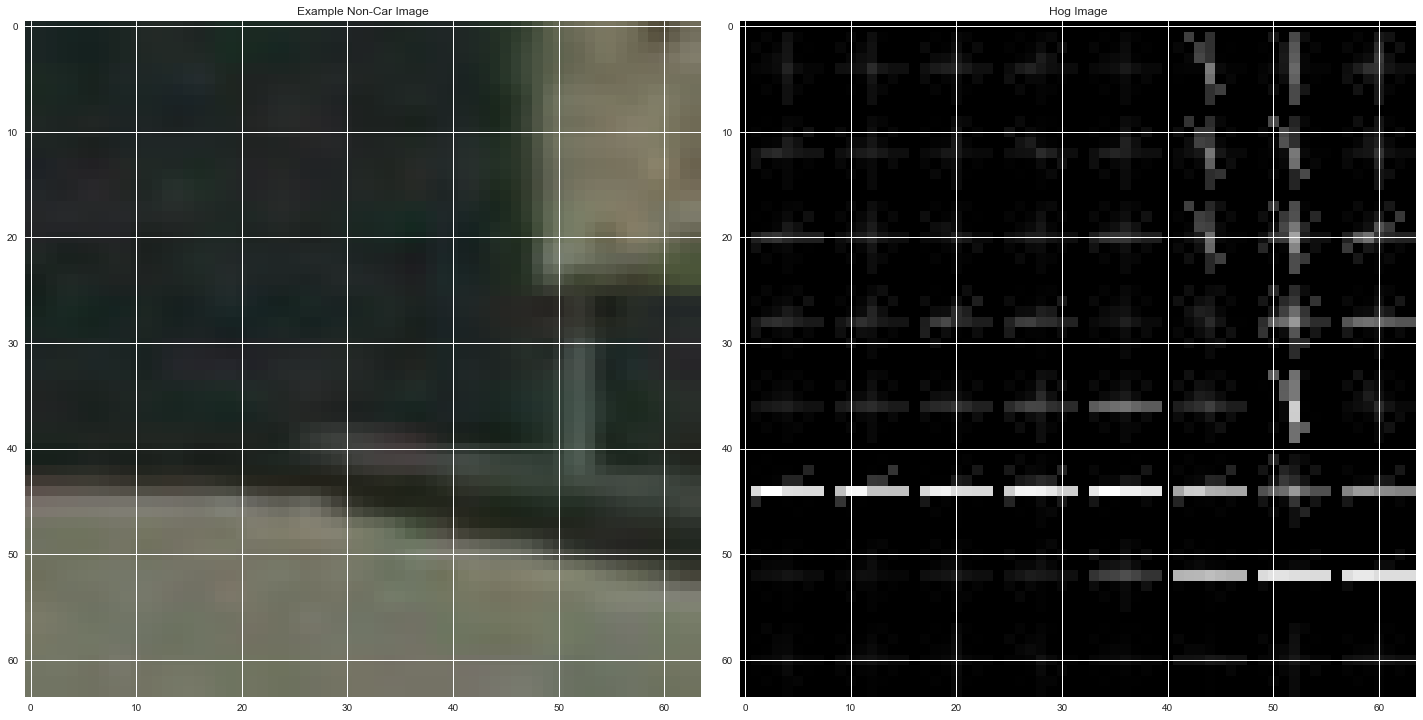

In [8]:
count = np.random.randint(0, len(cars),size=5)

color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

for i in count:
    image = imread(cars[i])
    car_features, car_hog_image = single_img_features(image, color_space='RGB', spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,vis=True)
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    f.tight_layout()
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Example Car Image')
    ax2.imshow(car_hog_image, cmap='gray')
    ax2.set_title('Hog Image')
    
for i in count:
    image = imread(notcars[i])
    notcar_features, notcar_hog_image = single_img_features(image, color_space='RGB', spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,vis=True)
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    f.tight_layout()
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Example Non-Car Image')
    ax2.imshow(notcar_hog_image, cmap='gray')
    ax2.set_title('Hog Image')

# Extract the HOG features

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Train Classifier and build datasets of Car and Non-car images to train a classifier

In [10]:
#train a classifier


color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
#n_samples = 1000
#random_indx=np.random.randint(0,len(cars),n_samples)
#test_cars = np.array(cars)[random_indx]
#test_notcars = np.array(notcars)[random_indx]

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell', cell_per_block,'cells per block',
     hist_bins,'histogram bins, and', spatial_size,'spacial sampling')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

87.08447813987732 Seconds to compute features
Using: 9 orientations 8 pixels per cell 2 cells per block 32 histogram bins, and (32, 32) spacial sampling
Feature vector length: 8460
22.49 Seconds to train SVC...
Test Accuracy of SVC =  0.9932


# slide_window
function that takes image and scrolls through the image start and stop positions in both x and y and overlap fractions (for both x and y)

In [11]:
#Function to scroll through the image using x y coordinates
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Search_windows
gets an image from slide_window and lists all the windows to be serch for.


### 1) Create an empty list to receive positive detection windows
### 2) Iterate over all windows in the list
### 3) Extract the test window from original image
### 4) Extract features for that window using single_img_features()
### 5) Scale extracted features to be fed to classifier
### 6) Predict using your classifier
### 7) If positive (prediction == 1) then save the window
### 8) Return windows for positive detections
        

In [12]:
# Gets an image from slide_window and lists all the windows to be serch for.
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows

# draw_boxes
used to draw the bounding boxes 

### Make a copy of the image
### Iterate through the bounding boxes
### Draw a rectangle given bbox coordinates
### Return the image copy with boxes drawn


In [13]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(123, 31, 162), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

0.8591444492340088 seconds to process on image searching 100 windows
0.8309066295623779 seconds to process on image searching 100 windows
0.7499425411224365 seconds to process on image searching 100 windows
0.7292699813842773 seconds to process on image searching 100 windows
0.8548338413238525 seconds to process on image searching 100 windows
0.944216251373291 seconds to process on image searching 100 windows


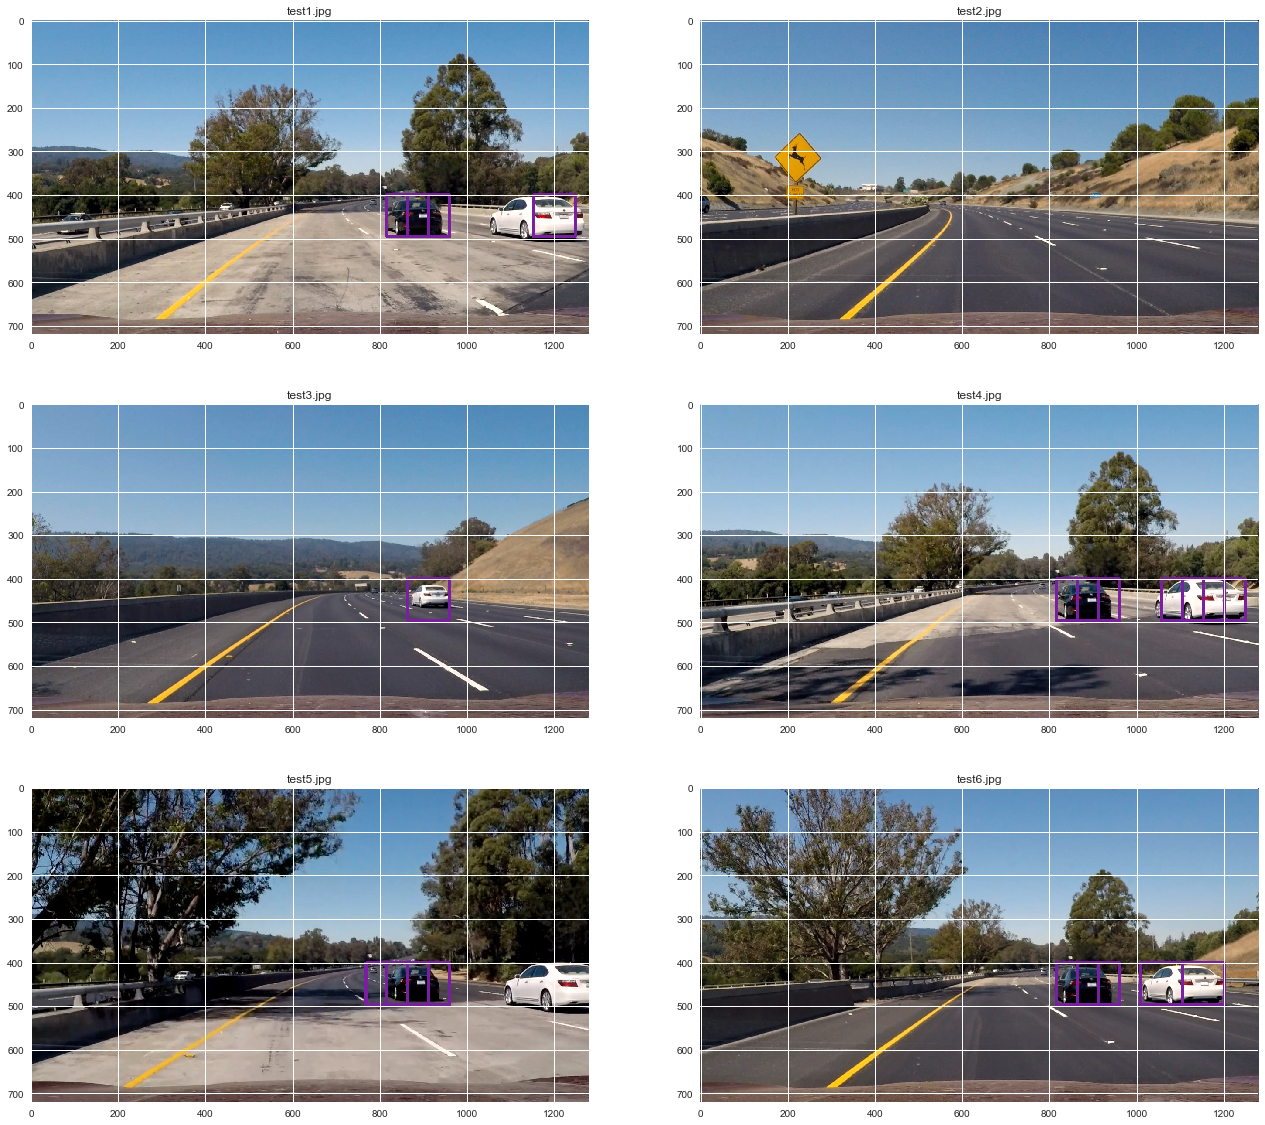

In [14]:
#test on test images
test_images = glob.glob('./test_images/*')
images = []
titles = []
y_start_stop=[400, 656]
overlap = 0.5

for img_src in test_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(overlap, overlap))
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_img,hot_windows,color=(123,31,162),thick=6)
    images.append(window_img)
    titles.append(img_src[-9:])
    print(time.time()-t1,'seconds to process on image searching',len(windows),'windows')
fig = plt.figure(figsize=(22,20))
visualize(fig,3,2,images,titles)


In [15]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv=='RGB2YCrCb':
        return cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    if conv=='BGR2YCrCb':
        return cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
    if conv=='RGB2LUV':
        return cv2.cvtColor(img,cv2.COLOR_RGB2LUV)

0.6816139221191406 seconds to run, total windows =  294
0.7447235584259033 seconds to run, total windows =  294
0.676978588104248 seconds to run, total windows =  294
0.6469717025756836 seconds to run, total windows =  294
0.7014973163604736 seconds to run, total windows =  294
0.7065002918243408 seconds to run, total windows =  294


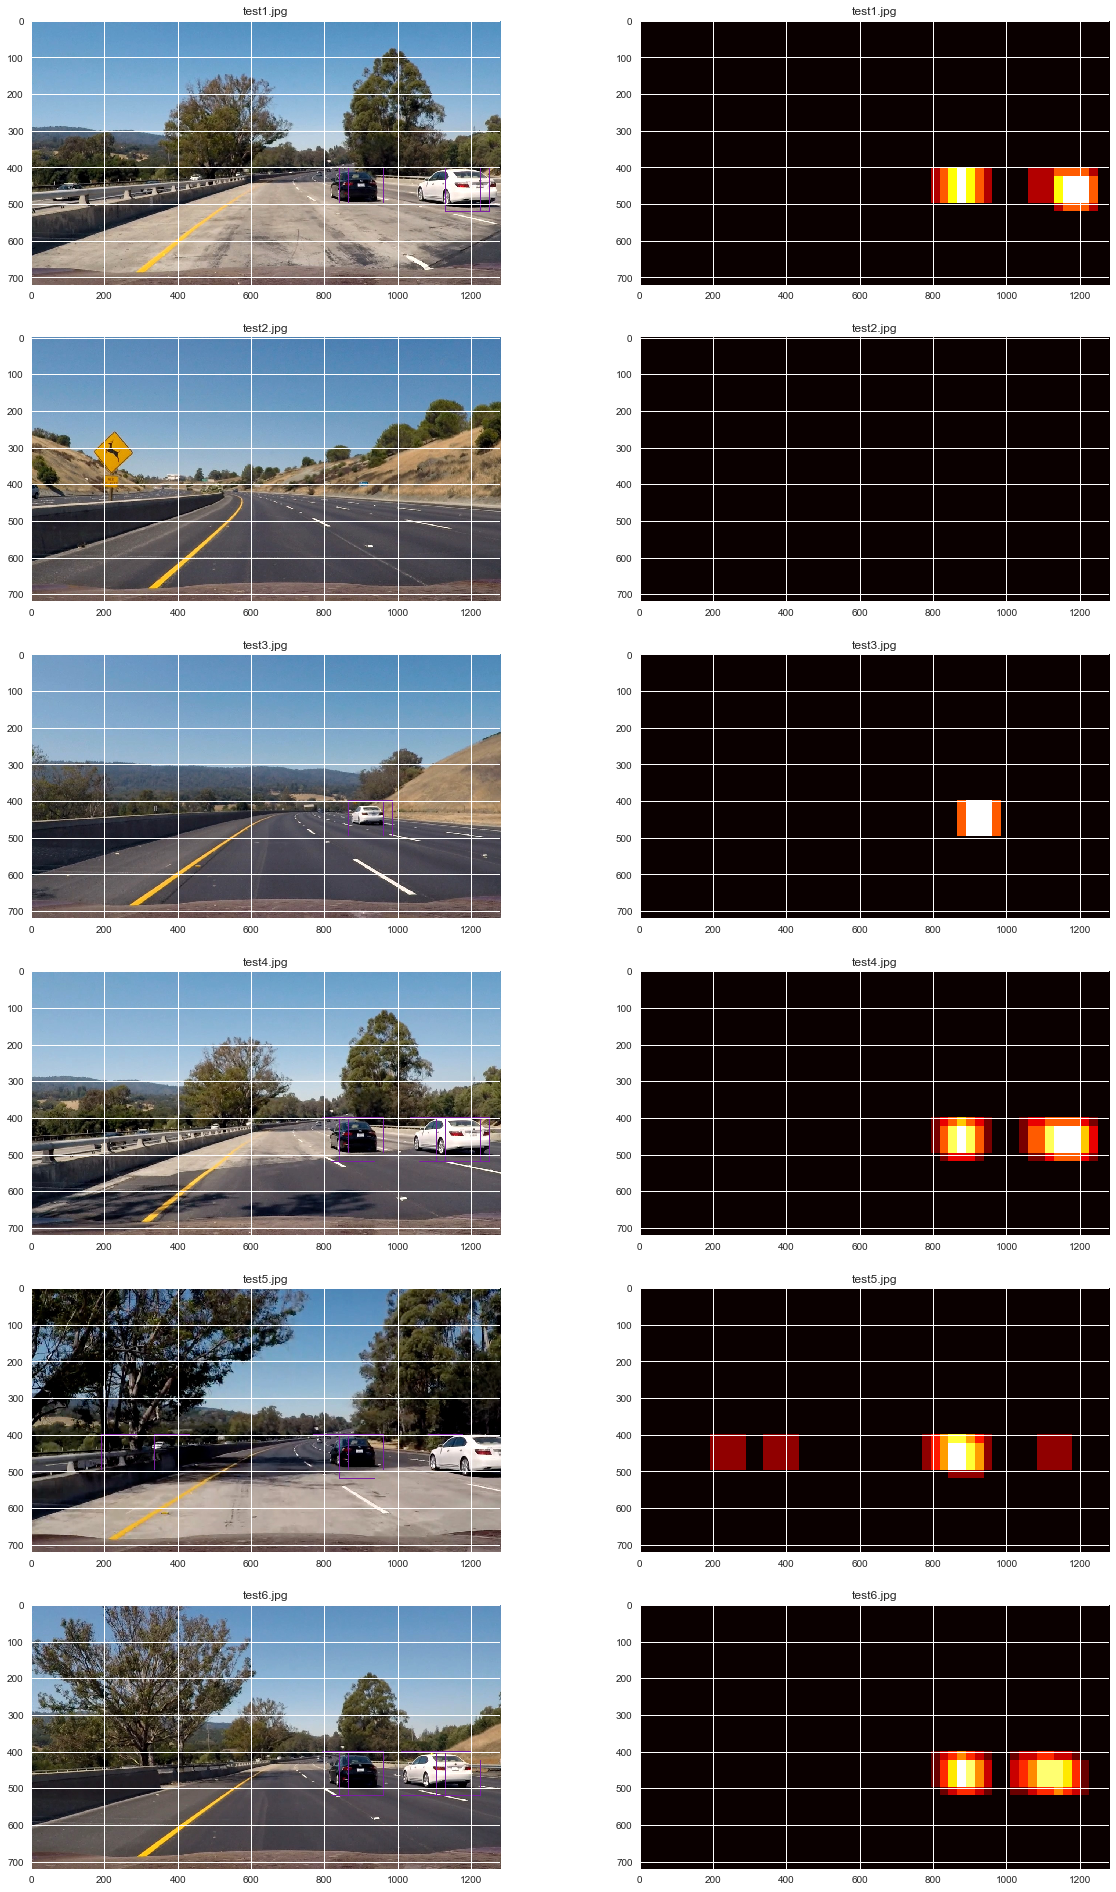

In [16]:
#implement heat map
test_images = glob.glob('./test_images/*')
out_images = []
out_maps = []
out_titles = []
out_boxes = []
ystart = 400
ystop = 656
scale = 1.5

for img_src in test_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    #heat map
    heatmap = np.zeros_like(img[:,:,0])
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
        
    #define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
    ##compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            #Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                
            #Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window], (64,64))
                
            #get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
                
            #scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
                
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart),(123,31,162))
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
                    
    print(time.time()-t, 'seconds to run, total windows = ', count)
        
    out_images.append(draw_img)
    out_titles.append(img_src[-9:])
    out_titles.append(img_src[-9:])
        
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
        
fig = plt.figure(figsize=(20,34))
visualize(fig,6,2,out_images,out_titles)
    

In [17]:
def find_cars(img, scale):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    #heat map
    heatmap = np.zeros_like(img[:,:,0])
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
        
    #define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
    ##compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            #Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                
            #Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window], (64,64))
                
            #get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
                
            #scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
                
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
                    
    return draw_img, heatmap

In [18]:
def draw_labeled_bboxes(img,labels):
    #iterative all detected cars
    for car_number in range(1,labels[1]+1):
        #find pixes with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        #Identify x and y values of those labels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        #define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox),np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy)))
        #draw the box on the image
        cv2.rectangle(img,bbox[0],bbox[1],(123,31,162),6)
    return img  

In [19]:
class Image():
    def __init__(self):
        self.sumheat_map = []
        
    def process_image(self,img):
        scale = 1.5
        out_img, heat_map = find_cars(img, scale)
        self.sumheat_map.append(heat_map)
        if len(self.sumheat_map) > 10:
            self.sumheat_map.pop(0)
        #heat_map = pre_heat_map * 0.8 + heat_map * 0.2
        heat_map = apply_threshold(sum(self.sumheat_map), 5)
        labels = label(heat_map)
        #draw bounding box on a copy of the image
        draw_img = draw_labeled_bboxes(np.copy(img),labels)
        #pre_heat_map = heat_map
        return draw_img    


In [20]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [21]:
# test video
video = Image()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
test_output = 'test_video_solution.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(video.process_image)
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_solution.mp4
[MoviePy] Writing video test_video_solution.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:21<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_solution.mp4 

Wall time: 23.5 s


In [22]:
# project video
video = Image()
test_output = 'project_video_solution.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video.process_image)
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_solution.mp4
[MoviePy] Writing video project_video_solution.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:57<00:00,  2.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_solution.mp4 

Wall time: 10min 59s
